In [33]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import pylab as pl
from PIL import Image

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


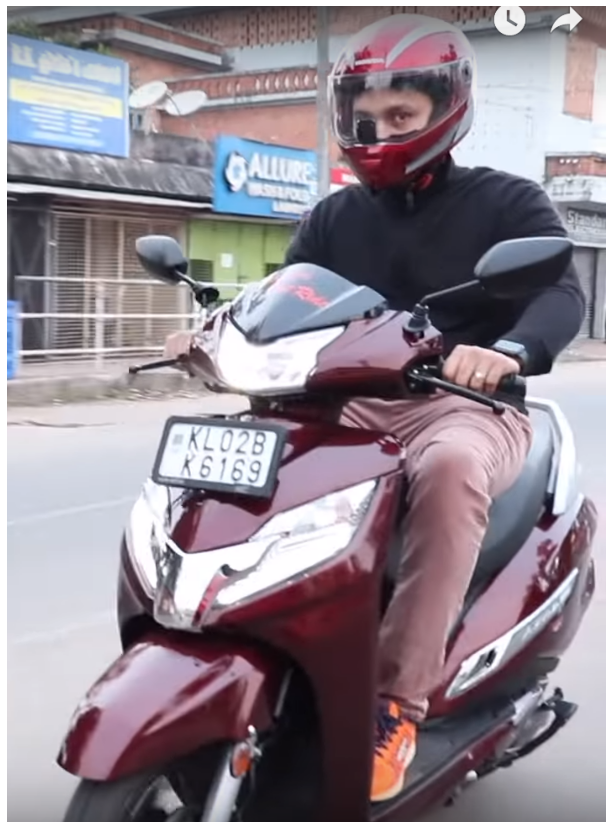

In [35]:
img0 = "/content/drive/MyDrive/Project/Pavithra-Helmet/dataset/obj/140.jpg"
_ = plt.figure(figsize = (15,15))
_ = plt.axis('off')
_ = plt.imshow(mpimg.imread(img0))

In [36]:
directory = '/content/drive/MyDrive/Project/Pavithra-Helmet/dataset/obj'

imagepath=[]
imagefile=[]
boxset=[]
boxfile=[]

for im in os.listdir(directory):
    if im[-4:]=='.jpg':
        path=os.path.join(directory,im)
        imagepath+=[path]
        imagefile+=[im]
        
for im in imagefile:
    if im[-4:]=='.jpg':
        bx=im[0:-4]+'.txt'
        path=os.path.join(directory,bx)
        if os.path.isfile(path):
            bxdata=np.loadtxt(path)
        boxset+=[bxdata]
        boxfile+=[bx]   

In [37]:
print(imagefile[0:5])
print(boxfile[0:5])

['114.jpg', '135__flip.jpg', '11.jpg', '135.jpg', '132__flip.jpg']
['114.txt', '135__flip.txt', '11.txt', '135.txt', '132__flip.txt']


In [38]:
print(len(boxset))
print(len(imagepath))

526
526


In [39]:
num0=0
for i in range(692):
    if imagepath[i]==img0:
        num0=i
        print(i)

93


IndexError: ignored

YOLO Detection

In [40]:
# for person on bike
weights0_path = '/content/drive/MyDrive/Project/Pavithra-Helmet/yolov3-obj_final.weights'
configuration0_path = '/content/drive/MyDrive/Project/Pavithra-Helmet/yolov3_pb.cfg'

probability_minimum = 0.5
threshold = 0.3

In [41]:
network0 = cv2.dnn.readNetFromDarknet(configuration0_path, weights0_path)
layers_names0_all = network0.getLayerNames()
layers_names0_output = [layers_names0_all[i[0]-1] for i in network0.getUnconnectedOutLayers()]
labels0 = open('/content/drive/MyDrive/Project/Pavithra-Helmet/coco.names').read().strip().split('\n')
print(labels0)

['person_bike']


In [42]:
# for helmet
weights1_path = '/content/drive/MyDrive/Project/Pavithra-Helmet/yolov3-helmet.weights'
configuration1_path = '/content/drive/MyDrive/Project/Pavithra-Helmet/yolov3-helmet.cfg'

In [43]:
network1 = cv2.dnn.readNetFromDarknet(configuration1_path, weights1_path)
layers_names1_all = network1.getLayerNames()
layers_names1_output = [layers_names0_all[i[0]-1] for i in network1.getUnconnectedOutLayers()]
labels1 = open('/content/drive/MyDrive/Project/Pavithra-Helmet/helmet.names').read().strip().split('\n')
print(labels1)

['Helmet']


In [44]:
image_input = cv2.imread(imagepath[num0])
blob = cv2.dnn.blobFromImage(image_input,1/255.0,(416,416),swapRB=True,crop=False)
blob_to_show = blob[0,:,:,:].transpose(1,2,0)
network0.setInput(blob)
network1.setInput(blob)
output_from_network0 = network0.forward(layers_names0_output)
output_from_network1 = network1.forward(layers_names1_output)
np.random.seed(42)
colours0 = np.random.randint(0,255,size=(len(labels0),3),dtype='uint8')
colours1 = np.random.randint(0,255,size=(len(labels1),3),dtype='uint8')

print(colours0)
print(colours1)

[[102 220 225]]
[[179  61 234]]


In [45]:
bounding_boxes0 = []
confidences0 = []
class_numbers0 = []

bounding_boxes1 = []
confidences1 = []
class_numbers1 = []

h,w = image_input.shape[:2]

for result in output_from_network0:
    for detection in result:
        scores = detection[5:]
        class_current=np.argmax(scores)
        confidence_current=scores[class_current]
        if confidence_current>probability_minimum:
            box_current=detection[0:4]*np.array([w,h,w,h])
            x_center,y_center,box_width,box_height=box_current.astype('int')
            x_min=int(x_center-(box_width/2))
            y_min=int(y_center-(box_height/2))
            
            bounding_boxes0.append([x_min,y_min,int(box_width),int(box_height)])
            confidences0.append(float(confidence_current))
            class_numbers0.append(class_current)
            
for result in output_from_network1:
    for detection in result:
        scores = detection[5:]
        class_current=np.argmax(scores)
        confidence_current=scores[class_current]
        if confidence_current>probability_minimum:
            box_current=detection[0:4]*np.array([w,h,w,h])
            x_center,y_center,box_width,box_height=box_current.astype('int')
            x_min=int(x_center-(box_width/2))
            y_min=int(y_center-(box_height/2))
            
            bounding_boxes1.append([x_min,y_min,int(box_width),int(box_height)])
            confidences1.append(float(confidence_current))
            class_numbers1.append(class_current)  

In [46]:
results0 = cv2.dnn.NMSBoxes(bounding_boxes0,confidences0,probability_minimum,threshold)

if len(results0) > 0:
    for i in results0.flatten():
        x_min,y_min=bounding_boxes0[i][0],bounding_boxes0[i][1]
        box_width,box_height= bounding_boxes0[i][2],bounding_boxes0[i][3]
        colour_box_current=[int(j) for j in colours0[class_numbers0[i]]]   
        cv2.rectangle(image_input,(x_min,y_min),(x_min+box_width,y_min+box_height),colour_box_current,5)
        text_box_current0='{}: {:.4f}'.format(labels0[int(class_numbers0[i])],confidences0[i])
        cv2.putText(image_input,text_box_current0,(x_min,y_min-7),cv2.FONT_HERSHEY_SIMPLEX,1.5,colour_box_current,5)

In [47]:
results1 = cv2.dnn.NMSBoxes(bounding_boxes1,confidences1,probability_minimum,threshold)

if len(results1) > 0:
    for i in results1.flatten():
        x_min,y_min=bounding_boxes1[i][0],bounding_boxes1[i][1]
        box_width,box_height= bounding_boxes1[i][2],bounding_boxes1[i][3]
        colour_box_current=[int(j) for j in colours1[class_numbers1[i]]]   
        cv2.rectangle(image_input,(x_min,y_min),(x_min+box_width,y_min+box_height),colour_box_current,5)
        text_box_current1='{}: {:.4f}'.format(labels1[int(class_numbers1[i])],confidences1[i])
        cv2.putText(image_input,text_box_current1,(x_min,y_min-7),cv2.FONT_HERSHEY_SIMPLEX,1.5,colour_box_current,5)

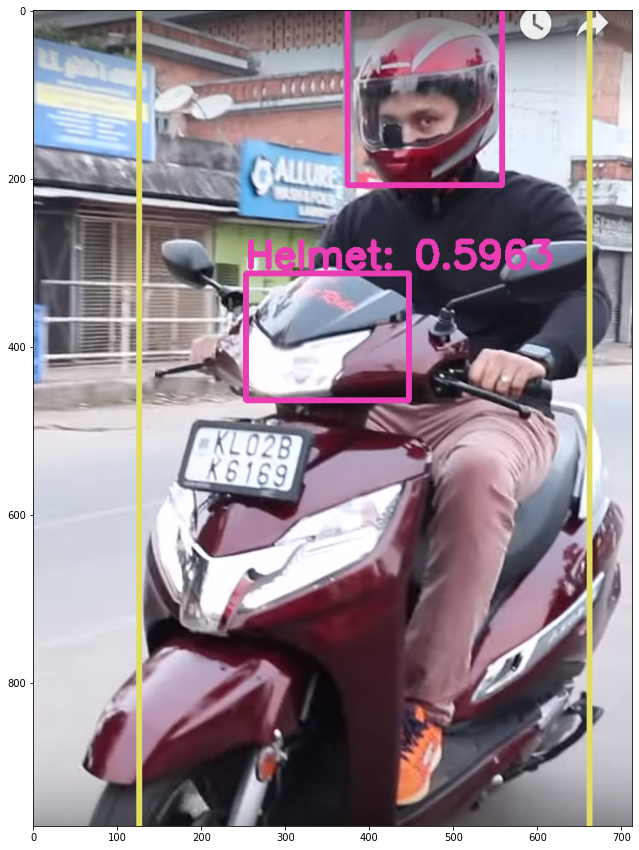

In [48]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0,15.0)
plt.imshow(cv2.cvtColor(image_input,cv2.COLOR_BGR2RGB))
plt.show()